In [112]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import linear_model

df = pd.read_csv("GroupExam2024_data_and_documentation/elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv", sep=';', decimal=',')
df.head()

,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),...,Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,-60.350,-46.133,NaN,...,Antarktisk krill,506.0,Antarktisk krill,706714.0,5.0,28 m og over,9432.0,NaN,19.87,133.88
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,74.885,16.048,20.0,...,Hyse,202.0,Hyse,9594.0,5.0,28 m og over,1476.0,NaN,12.60,56.80
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,74.885,16.048,20.0,...,Torsk,201.0,Torsk,8510.0,5.0,28 m og over,1476.0,NaN,12.60,56.80
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,74.885,16.048,20.0,...,Blåkveite,301.0,Blåkveite,196.0,5.0,28 m og over,1476.0,NaN,12.60,56.80
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,74.885,16.048,20.0,...,Sei,203.0,Sei,134.0,5.0,28 m og over,1476.0,NaN,12.60,56.80


In [113]:
#Sile ut informasjon:
df = df[(df['Art - FDIR (kode)'] == 1022) | (df['Art - FDIR (kode)'] == 1027)] # Fiske som fanger hyse eller torsk.
df = df[df['Redskap FDIR (kode)'] == 51] # Fiske med bunntrål
df['Bruttotonnasje Kombinert'] = df['Bruttotonnasje 1969'].fillna(df['Bruttotonnasje annen']) # Slår sammen kolonnene.
# Dropper unødvendig informasjon. Tabellen inneholder masse duplikater. som egen kolonne for navn og for kode
# Forskjellige klassifiseringsmåter. Holder på FDIR sine.
df.drop(columns = ['Meldingsdato', 
                   'Meldingsklokkeslett', 
                   'Startdato',  
                   'Hovedområde start', 
                   'Lokasjon start (kode)', 
                   'Stoppdato', 
                   'Stoppklokkeslett', 
                   'Fangstår', 
                   'Hovedområde stopp (kode)', 
                   'Hovedområde stopp', 
                   'Lokasjon stopp (kode)', 
                   'Redskap FAO (kode)', 
                   'Redskap FAO', 
                   'Redskap FDIR', 
                   'Hovedart FAO (kode)', 
                   'Hovedart FAO', 
                   'Art FAO (kode)',
                   'Art FAO',
                   'Art - gruppe', 
                   'Lengdegruppe', 
                   'Bredde', 
                   'Fartøylengde',
                   'Bruttotonnasje 1969',
                   'Bruttotonnasje annen'
    ], inplace=True)

# Gruppere bruttotonnasje:
bins = [x for x in range(0, 4800, 100)] # Definerer gruppene
labels = range(1, len(bins))  # nummererer gruppene.
# Categorize 'Bruttotonnasje Kombinert' into the defined bins
df['Bruttotonnasje Gruppert'] = pd.cut(df['Bruttotonnasje Kombinert'], bins=bins, labels=labels)
# Teller grupperingene
df['Bruttotonnasje Gruppert'].value_counts()

Bruttotonnasje Gruppert
35    4829
12    4243
15    2997
19    2688
16    2471
25    2076
32    1942
6     1730
3     1554
2     1522
7     1522
17    1298
38    1237
34    1120
23     976
14     973
21     923
45     837
36     820
27     807
40     689
26     671
42     636
4      615
1      470
5      347
24       3
20       2
28       0
39       0
46       0
8        0
44       0
43       0
9        0
41       0
10       0
11       0
29       0
37       0
13       0
18       0
33       0
22       0
31       0
30       0
47       0
Name: count, dtype: int64

In [114]:
def join_unique_values(series):
    return ', '.join(series.dropna().astype(str).unique())

aggregated_df = df.groupby(['Melding ID'], as_index=False).agg({
    'Startposisjon bredde': 'first',  # Antar at verdiene er lik for dei ulike radene. Tar med informasjon frå første raden som slås sammen
    'Startposisjon lengde': 'first',
    'Starttidspunkt': 'first',
    'Havdybde start': 'first',
    'Stopptidspunkt': 'last',
    'Varighet': 'sum', 
    'Stopposisjon bredde': 'last',  # Slår sammen og bruker verdien fra siste raden.
    'Stopposisjon lengde': 'last',
    'Havdybde stopp': 'last',
    'Trekkavstand': 'sum',  # summer opp dei ulike radene.
    'Redskap FDIR (kode)': join_unique_values,
    'Hovedart - FDIR (kode)': join_unique_values, # Tar med verdiene fra dei ulike radene og slår dei sammen til ein tekststreng.
    'Art - FDIR (kode)': join_unique_values,
    'Art - gruppe (kode)': join_unique_values,
    'Rundvekt': 'sum',  # Summing up the total weight
    'Lengdegruppe (kode)': 'first',  # Assuming to take the first value
    'Bruttotonnasje Gruppert': 'first'  # Assuming to take the first value
})
aggregated_df['Bruttotonnasje Gruppert'].value_counts()

Bruttotonnasje Gruppert
35    900
12    812
3     787
2     738
15    619
19    527
6     436
16    431
25    427
4     398
32    370
1     335
17    277
7     269
21    234
38    203
36    197
34    196
14    191
23    182
40    174
45    161
5     161
27    155
42    130
26    120
24      2
20      2
28      0
39      0
46      0
8       0
44      0
43      0
9       0
41      0
10      0
11      0
29      0
37      0
13      0
18      0
33      0
22      0
31      0
30      0
47      0
Name: count, dtype: int64

In [115]:
aggregated_df

,Melding ID,Startposisjon bredde,Startposisjon lengde,Starttidspunkt,Havdybde start,Stopptidspunkt,Varighet,Stopposisjon bredde,Stopposisjon lengde,Havdybde stopp,Trekkavstand,Redskap FDIR (kode),Hovedart - FDIR (kode),Art - FDIR (kode),Art - gruppe (kode),Rundvekt,Lengdegruppe (kode),Bruttotonnasje Gruppert
0,1497178,74.885,16.048,30.12.2017 23:21,-335,31.12.2017 21:47,2240,74.926,15.894,-358,56990.0,51.0,"1027.0, 1022.0","1027.0, 1022.0","202.0, 201.0",65182.0,5.0,15
1,1497311,73.127,28.324,01.01.2018 17:09,-302,01.01.2018 18:36,174,73.187,28.390,-258,14056.0,51.0,1022.0,"1022.0, 1027.0","201.0, 202.0",4052.0,5.0,19
2,1497330,74.307,30.293,01.01.2018 01:16,-317,01.01.2018 21:58,974,74.190,30.274,-319,36290.0,51.0,1022.0,1022.0,201.0,74100.0,5.0,45
3,1497342,71.349,26.933,01.01.2018 00:59,-258,01.01.2018 20:32,2040,71.292,24.904,-294,91398.0,51.0,1022.0,"1022.0, 1027.0","201.0, 202.0",13736.0,5.0,7
4,1497352,71.227,24.085,01.01.2018 01:16,-317,01.01.2018 18:28,1768,71.157,23.390,-307,92992.0,51.0,1022.0,"1022.0, 1027.0","201.0, 202.0",19698.0,5.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9429,1800260,74.207,17.754,30.12.2018 23:34,-203,31.12.2018 18:21,2024,74.441,16.382,-321,180752.0,51.0,"1022.0, 1027.0","1022.0, 1027.0","201.0, 202.0",31724.0,5.0,25
9430,1800268,74.957,16.174,30.12.2018 22:50,-229,31.12.2018 23:40,2032,76.532,14.122,-192,232952.0,51.0,1022.0,"1022.0, 1027.0","201.0, 202.0",35245.0,5.0,19
9431,1800285,74.892,17.255,31.12.2018 00:26,-228,31.12.2018 22:58,2220,74.232,16.529,-283,215352.0,51.0,1022.0,"1022.0, 1027.0","201.0, 202.0",27619.0,5.0,35
9432,1800286,70.888,22.321,31.12.2018 09:50,-111,31.12.2018 18:59,616,70.877,22.188,-178,7433.0,51.0,1032.0,"1022.0, 1027.0","201.0, 202.0",4375.0,5.0,7


In [116]:
features = ['Bruttotonnasje Gruppert', 'Trekkavstand', 'Varighet', 'Havdybde start', 'Rundvekt']

df_cleaned = df.dropna(subset=features)

data = df_cleaned[features]
predict = 'Rundvekt'

X = np.array(data.drop([predict], axis=1))
y = np.array(data[predict])

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.1)

linear = linear_model.LinearRegression()
linear.fit(x_train, y_train)
score = linear.score(x_test, y_test)
print(score)

0.06243246797615076


/var/folders/87/czlwvtcd4j3cz6jlhc_45ld00000gn/T/ipykernel_2333/1962164348.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bruttotonn_count = aggregated_df.groupby('Bruttotonnasje Gruppert').size()


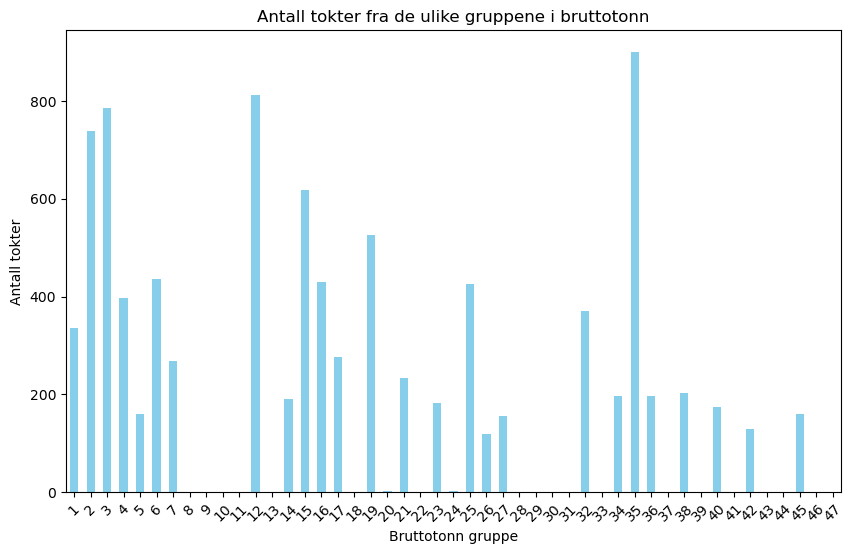

In [117]:
import matplotlib.pyplot as plt
# Gruppert etter størrelse på båten
bruttotonn_count = aggregated_df.groupby('Bruttotonnasje Gruppert').size()

# Genererer diagram
plt.figure(figsize=(10, 6))
bruttotonn_count.plot(kind='bar', color='skyblue')
plt.title('Antall tokter fra de ulike gruppene i bruttotonn')
plt.xlabel('Bruttotonn gruppe')
plt.ylabel('Antall tokter')
plt.xticks(rotation=45)
plt.show()

In [118]:
# Group the data by 'Bruttotonnasje Gruppert' and calculate the sum of 'Rundvekt' for each group
rundvekt_total_per_group = aggregated_df.groupby('Bruttotonnasje Gruppert')['Rundvekt'].sum()

/var/folders/87/czlwvtcd4j3cz6jlhc_45ld00000gn/T/ipykernel_2333/4084052864.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rundvekt_total_per_group = aggregated_df.groupby('Bruttotonnasje Gruppert')['Rundvekt'].sum()


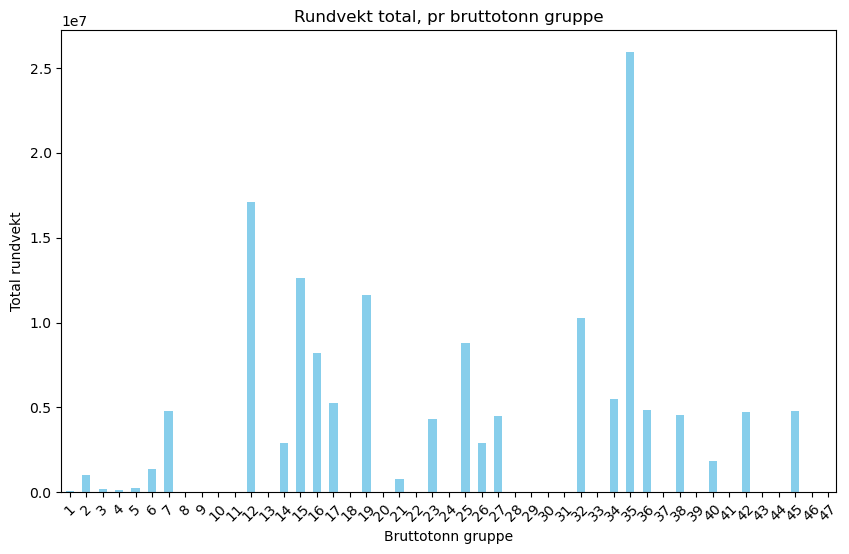

In [119]:
# Genererer diagram
plt.figure(figsize=(10, 6))
rundvekt_total_per_group.plot(kind='bar', color='skyblue')
plt.title('Rundvekt total, pr bruttotonn gruppe')
plt.xlabel('Bruttotonn gruppe')
plt.ylabel('Total rundvekt')
plt.xticks(rotation=45)
plt.show()

/var/folders/87/czlwvtcd4j3cz6jlhc_45ld00000gn/T/ipykernel_2333/1978392869.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_rundvekt_gruppe = aggregated_df.groupby('Bruttotonnasje Gruppert')['Rundvekt'].mean()


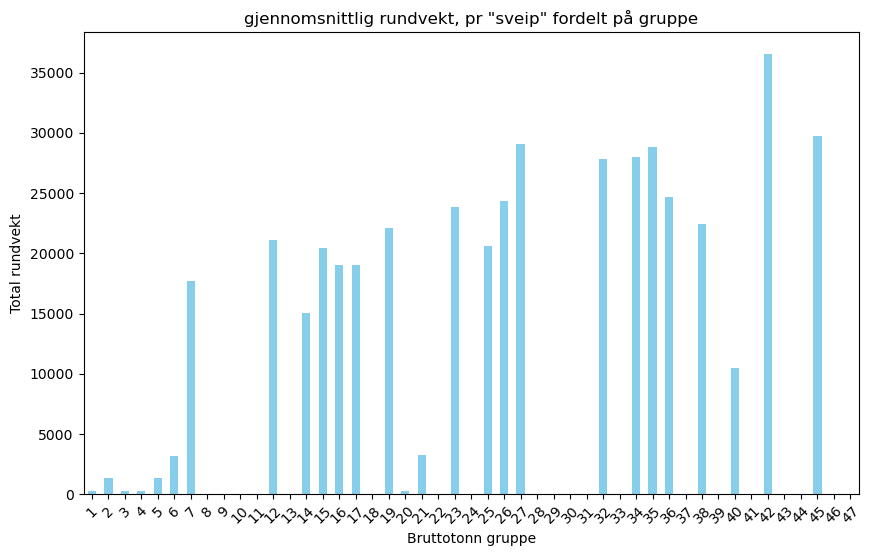

In [120]:
average_rundvekt_gruppe = aggregated_df.groupby('Bruttotonnasje Gruppert')['Rundvekt'].mean()

plt.figure(figsize=(10, 6))
average_rundvekt_gruppe.plot(kind='bar', color='skyblue')
plt.title('gjennomsnittlig rundvekt, pr "sveip" fordelt på gruppe')
plt.xlabel('Bruttotonn gruppe')
plt.ylabel('Total rundvekt')
plt.xticks(rotation=45)
plt.show()

/var/folders/87/czlwvtcd4j3cz6jlhc_45ld00000gn/T/ipykernel_2333/815291654.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_rundvekt_gruppe = aggregated_df.groupby('Bruttotonnasje Gruppert')['Rundvekt'].max()


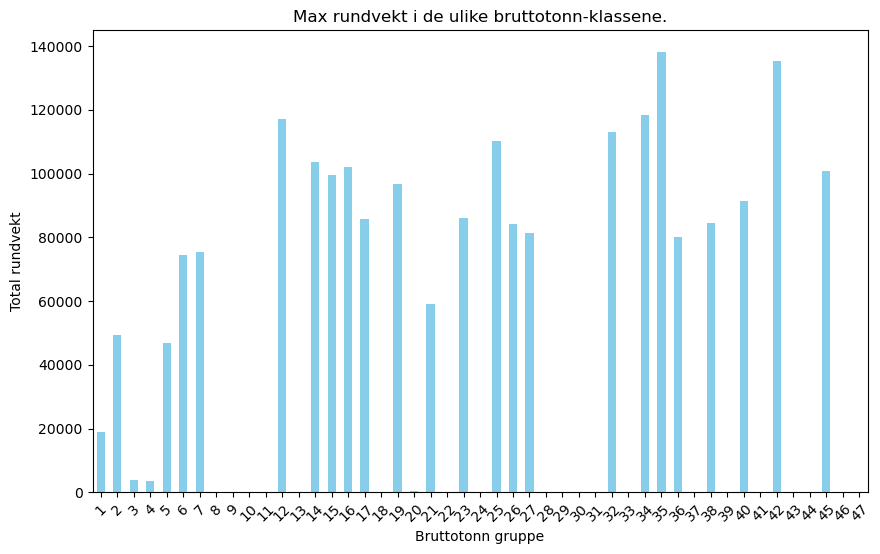

In [121]:
# Regne ut max kapasitet fra de ulike Bruttotonn-klassene.
max_rundvekt_gruppe = aggregated_df.groupby('Bruttotonnasje Gruppert')['Rundvekt'].max()

plt.figure(figsize=(10, 6))
max_rundvekt_gruppe.plot(kind='bar', color='skyblue')
plt.title('Max rundvekt i de ulike bruttotonn-klassene.')
plt.xlabel('Bruttotonn gruppe')
plt.ylabel('Total rundvekt')
plt.xticks(rotation=45)
plt.show()

In [122]:
# Finne ut forventet rundvekt pr klasse. 

In [123]:
features = ['Bruttotonnasje Gruppert', 'Trekkavstand', 'Varighet', 'Havdybde start', 'Rundvekt']

df_cleaned = aggregated_df.dropna(subset=features)

data = df_cleaned[features]
predict = 'Rundvekt'     # Får best resultater med trekkavstand som target value...

X = np.array(data.drop([predict], axis=1))
y = np.array(data[predict])

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)

linear = linear_model.LinearRegression()
linear.fit(x_train, y_train)
score = linear.score(x_test, y_test)
print(score)

0.033744360330831946


Resultater:
Rundvekt: 0.3073831319977236
Trekkavstand: 0.40293255889993773

In [124]:
len(y_train)

7547

ValueError: 'c' argument has 7547 elements, which is inconsistent with 'x' and 'y' with size 9434.

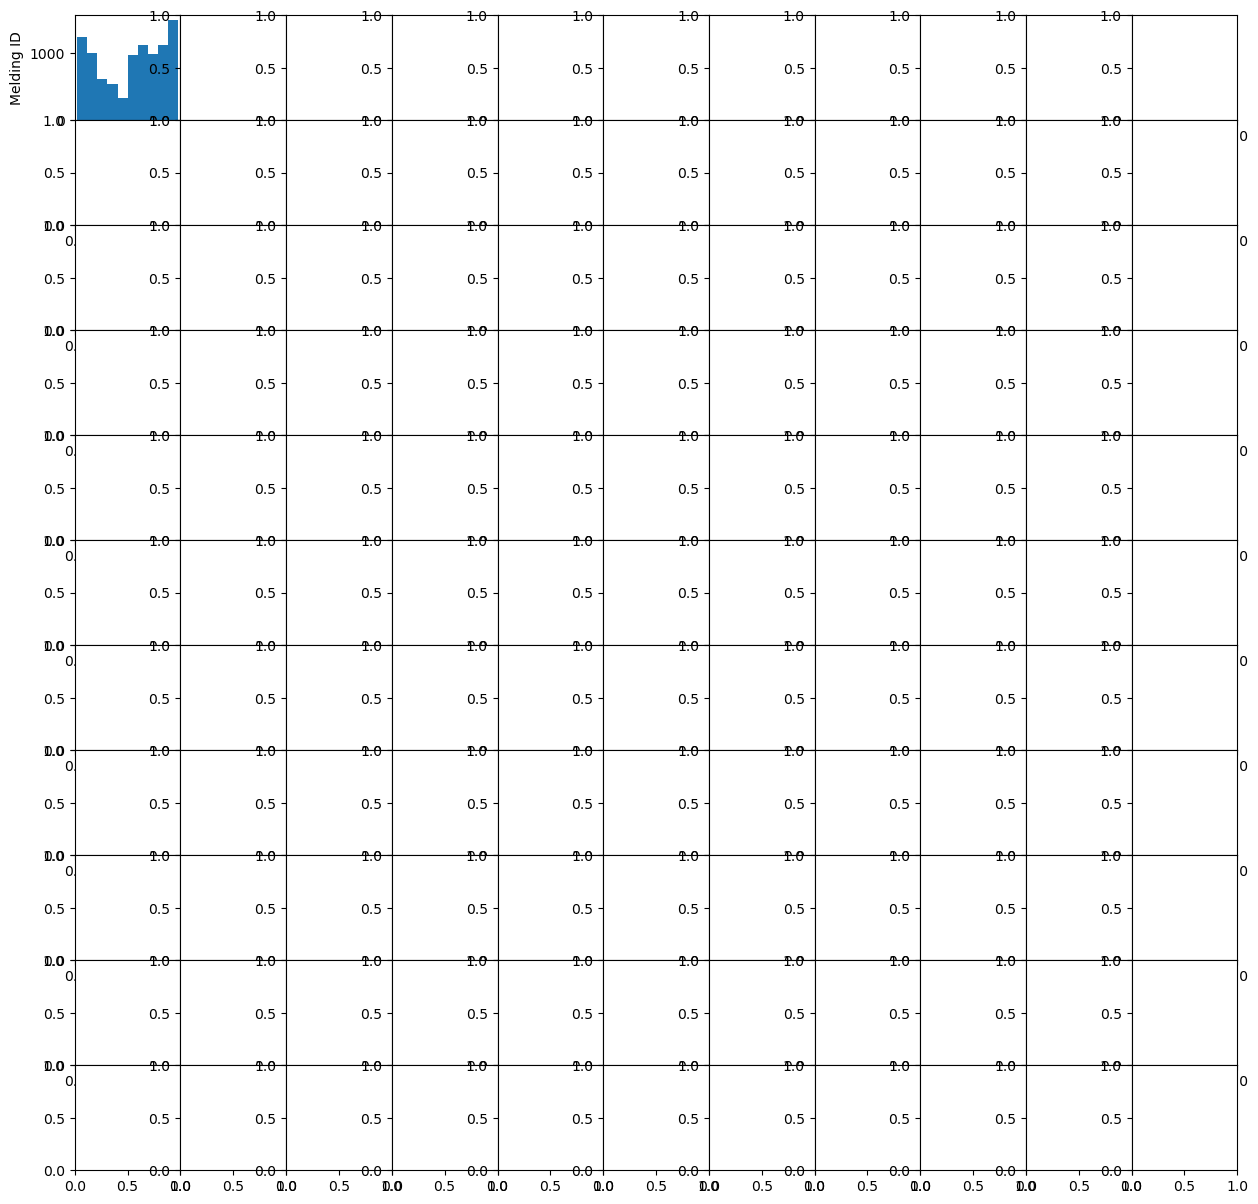

In [125]:
grr = pd.plotting.scatter_matrix(df_cleaned, c=y_train, figsize=(15, 15), marker='o', s=60, alpha=.8)
# Assuming X and y_train are already defined
plot_frame = pd.DataFrame(X, columns=features)  # Use actual feature names

grr = pd.plotting.scatter_matrix(plot_frame, c=y_train, figsize=(15, 15), marker='o', s=60, alpha=.8)
plt.show()  # Ensure the plot displays in some environments